In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from scipy.integrate import quad

def generate_synthetic_data(true_params, num_periods):
    # Extract parameter values from true_params
    theta_i, alpha, gamma, rho_2, mu, sigma = true_params

    # Initialize arrays to store the generated data
    ait = np.zeros(num_periods)
    dit = np.zeros(num_periods)
    rit = np.zeros(num_periods)
    yit = np.zeros(num_periods)

    # Set initial values for state variables
    xt = 0
    zt = 0
    Rt = 0
    Ra_t = 0

    # Generate data for each period
    for t in range(num_periods):
        # Generate addition action (ait) from a non-parametric distribution
        ait[t] = np.random.choice([0, 1, 2, 3], p=[0.4, 0.3, 0.2, 0.1])

        # Evaluate the pseudo-Expected Value Functions (pseudo-EVF) using Equation 4
        Vit = theta_i * xt + gamma * (1 if zt >= 1 else 0) + rho_2 * Rt**2 + mu * Ra_t

        # Generate upgrade action (yit) using a Bernoulli distribution
        yit[t] = np.random.binomial(1, np.exp(Vit) / (1 + np.exp(Vit)))

        # Generate referral action (rit) using a Poisson distribution with a maximum limit of 32 referrals
        rit[t] = np.minimum(np.random.poisson(mu), 32)

        # Generate deletion action (dit) using Equation 2
        dit[t] = np.maximum(0, np.minimum(xt + ait[t], alpha * xt + np.random.normal(0, sigma)))

        # Update state variables using the state evolution equations from Table 2
        xt = xt + ait[t] - dit[t]
        zt = np.maximum(0, zt - 1) + yit[t]
        Rt = Rt + rit[t]
        Ra_t = Ra_t + np.random.binomial(rit[t], 0.467)  # Empirical referral acceptance rate of 46.7%

    return ait, dit, rit, yit

def evaluate_pseudo_evf(params, state_vars):
    # Extract parameter values from params
    theta_i, alpha, gamma, rho_2, mu, sigma = params

    # Extract state variables
    xt, zt, Rt, Ra_t = state_vars

    # Evaluate the pseudo-Expected Value Functions (pseudo-EVF) using Equation 4
    Vit = theta_i * xt + gamma * (zt >= 1).astype(int) + rho_2 * Rt**2 + mu * Ra_t

    # Reshape Vit to match the dimensions of pseudo_evf
    if isinstance(xt, np.ndarray):
        num_periods = len(xt)
        Vit = Vit.reshape((num_periods, 1, 1))
        Vit = np.tile(Vit, (1, 2, 33))
    else:
        Vit = Vit.reshape((1, 1, 1))
        Vit = np.tile(Vit, (1, 2, 33))

    return Vit

def calculate_pseudo_likelihood(params, data, pseudo_evf):
    # Extract data variables
    ait, dit, rit, yit = data

    # Extract state variables
    xt, zt, Rt, Ra_t = [var[:-1] for var in data]  # Exclude the last observation for each state variable

    # Calculate the discrete choice likelihood contribution using the formula from the paper
    discrete_likelihood = np.exp(pseudo_evf[np.arange(len(yit)-1), yit[:-1].astype(int), rit[:-1].astype(int)]) / np.sum(np.exp(pseudo_evf), axis=(1, 2))

    # Calculate the continuous choice likelihood contribution using the formula from the paper
    g_inv = dit[:-1] - params[1] * xt
    continuous_likelihood = stats.norm.pdf(g_inv, loc=0, scale=params[5]) * np.abs(params[1])

    # Combine the discrete and continuous likelihood contributions
    pseudo_likelihood = discrete_likelihood * continuous_likelihood

    # Use quadrature to approximate the integral over the deletion shock ν
    def integrand(nu):
        return stats.norm.pdf(nu, loc=0, scale=params[5]) * np.abs(params[1])

    # Add a small positive value to avoid numerical issues
    pseudo_likelihood += 1e-10

    pseudo_likelihood *= quad(integrand, -np.inf, np.inf)[0]

    # Handle boundary cases and censored observations (Sections A.1, A.1.1, A.1.2)
    # Implement the deletion bounds and log-likelihood calculations as per the paper
    deletion_lower_bound = np.maximum(0, xt + ait[:-1] - params[0] * (params[2] + params[3] * Ra_t))
    deletion_upper_bound = xt + ait[:-1]

    # Calculate the probability of observing the deletion action within the bounds
    prob_within_bounds = stats.norm.cdf(deletion_upper_bound, loc=params[1] * xt, scale=params[5]) - \
                         stats.norm.cdf(deletion_lower_bound, loc=params[1] * xt, scale=params[5])

    # Adjust the pseudo-likelihood for the boundary cases
    pseudo_likelihood *= prob_within_bounds
    pseudo_likelihood = np.clip(pseudo_likelihood, 1e-10, None)

    # Calculate the log-likelihood
    log_likelihood = np.log(pseudo_likelihood)

    return log_likelihood.sum()

  
   

def metropolis_hastings_step(params, data, pseudo_evf, proposal_dist):
    # Propose new parameter values (Θ*k) using the proposal distribution
    proposed_params = proposal_dist.rvs()

    # Calculate the acceptance probability using the Metropolis-Hastings ratio
    current_likelihood = calculate_pseudo_likelihood(params, data, pseudo_evf)
    proposed_likelihood = calculate_pseudo_likelihood(proposed_params, data, pseudo_evf)

    # Scale the log-likelihoods to avoid numerical issues
    current_likelihood = current_likelihood / np.abs(current_likelihood).max()
    proposed_likelihood = proposed_likelihood / np.abs(proposed_likelihood).max()

    log_acceptance_prob = proposed_likelihood - current_likelihood
    acceptance_prob = np.exp(np.minimum(0, log_acceptance_prob)).mean()

    # Accept or reject the proposed parameters based on the acceptance probability
    # Check for non-finite likelihood values and handle them
    if not np.isfinite(current_likelihood):
        current_likelihood = -np.inf
    if not np.isfinite(proposed_likelihood):
        proposed_likelihood = -np.inf

    log_acceptance_prob = proposed_likelihood - current_likelihood
    acceptance_prob = np.exp(np.minimum(0, log_acceptance_prob))

    # Accept or reject the proposed parameters based on the acceptance probability
    if np.random.rand() < acceptance_prob:
        accepted_params = proposed_params
    else:
        accepted_params = params

    return accepted_params

def update_pseudo_value_function(params, data, pseudo_evf):
    # Create a new pseudo-Value Function by evaluating the Bellman operator on Equation 3
    new_pseudo_evf = np.zeros_like(pseudo_evf)

    for t in range(len(data[0]) - 1):
        # Extract state variables for the current period
        xt = data[0][t]  # ait
        zt = data[1][t]  # dit
        Rt = data[2][t]  # rit
        Ra_t = data[3][t] * 0.467  # yit * empirical referral acceptance rate

        # Evaluate the pseudo-EVF for the current state
        Vit = evaluate_pseudo_evf(params, [xt, zt, Rt, Ra_t])

        # Update the pseudo-Value Function using the Bellman operator
        if t < len(data[0]) - 2:
            new_pseudo_evf[t] = Vit + params[-1] * np.log(np.sum(np.exp(pseudo_evf[t+1])))
        else:
            new_pseudo_evf[t] = Vit

    return new_pseudo_evf

def ijc_algorithm(data, num_iterations, initial_params=None):
    # Initialize parameter values using prior distributions from the paper or provided initial values
    if initial_params is None:
        theta_i = np.random.normal(0.05, 0.01)
        alpha = np.random.normal(-0.7, 0.1)
        gamma = np.random.normal(-0.4, 0.1)
        rho_2 = np.random.normal(-0.5, 0.1)
        mu = np.random.normal(0.6, 0.1)
        sigma = np.random.gamma(1, 0.1)
        params = np.array([theta_i, alpha, gamma, rho_2, mu, sigma])
    else:
        params = initial_params

    # Initialize the pseudo-Expected Value Functions (pseudo-EVF)
    pseudo_evf = np.zeros((len(data[0]), 2, 33))  # Updated dimensions based on the paper

    # Define the proposal distribution for Metropolis-Hastings
    proposal_dist = stats.multivariate_normal(mean=params, cov=np.eye(len(params)) * 0.1)

    # Run MCMC for num_iterations
    posterior_samples = np.zeros((num_iterations, len(params)))
    for i in range(num_iterations):
        # Extract state variables for the current period
        xt, zt, Rt, Ra_t = data[0][:-1], data[1][:-1], data[2][:-1], data[3][:-1]

        # Evaluate the pseudo-Expected Value Functions (pseudo-EVF)
        pseudo_evf = evaluate_pseudo_evf(params, [xt, zt, Rt, Ra_t])

        # Calculate the pseudo-likelihood values
        pseudo_likelihood = calculate_pseudo_likelihood(params, data, pseudo_evf)

        # Use the Metropolis-Hastings step to accept or reject the proposed parameters
        params = metropolis_hastings_step(params, data, pseudo_evf, proposal_dist)

        # Update the pseudo-Value Function
        pseudo_evf = update_pseudo_value_function(params, data, pseudo_evf)

        # Store the accepted parameters
        posterior_samples[i] = params

    return posterior_samples

def compute_posterior_stats(posterior_samples):
    # Compute the mean and 95% HPD intervals for each parameter
    posterior_means = np.mean(posterior_samples, axis=0)
    posterior_hpd = np.percentile(posterior_samples, [2.5, 97.5], axis=0).T

    return posterior_means, posterior_hpd

/var/folders/_b/ccc66ybs0m59z0yyhly4_jp80000gn/T/ipykernel_71805/223225642.py:92: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  pseudo_likelihood *= quad(integrand, -np.inf, np.inf)[0]


Posterior Means:
[ 0.0609569  -0.51031113 -0.36009629 -0.375569    0.65537498  0.43496767]
95% HPD Intervals:
[[-0.55718933  0.67511827]
 [-1.14486825  0.11482116]
 [-0.97844755  0.2616926 ]
 [-0.99955809  0.23060344]
 [ 0.03810234  1.27268792]
 [ 0.03317139  1.00247254]]


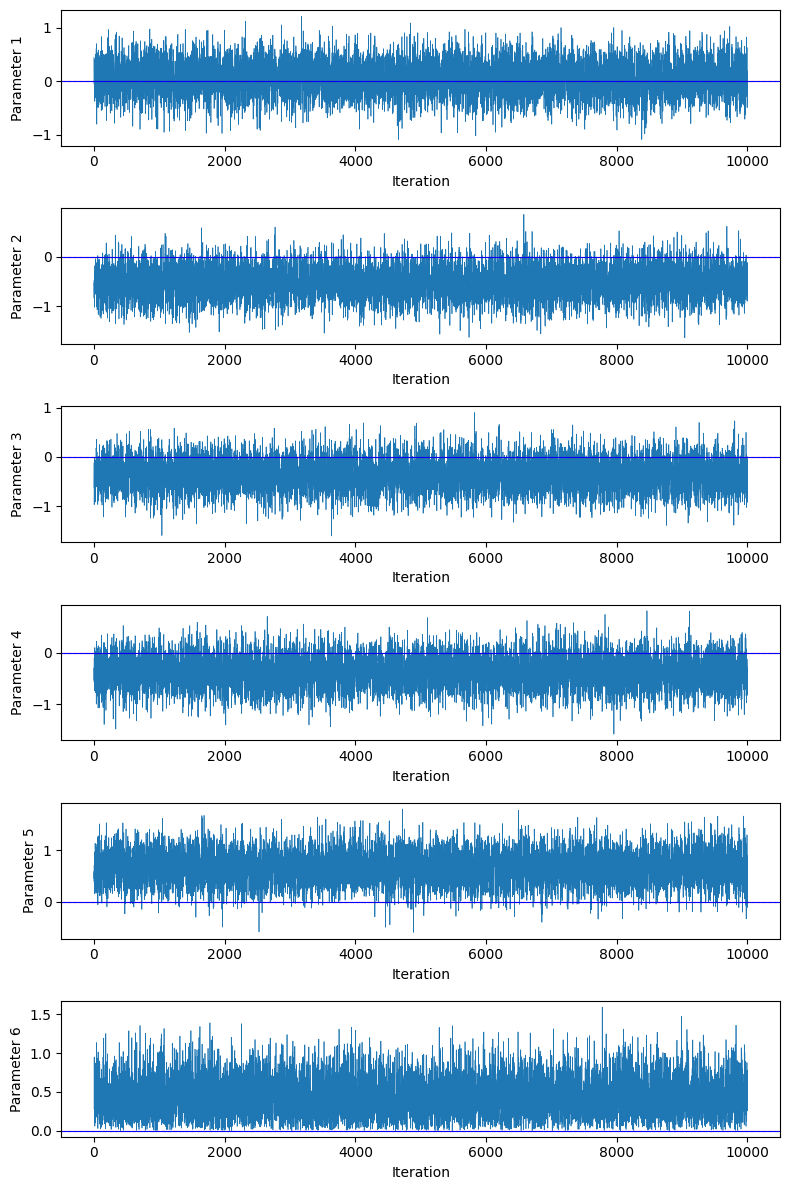

In [2]:
def plot_mcmc_traceplots(posterior_samples, true_params):
    num_params = len(true_params)
    fig, axes = plt.subplots(num_params, 1, figsize=(8, 2*num_params))

    for i in range(num_params):
        axes[i].plot(posterior_samples[:, i], linewidth=0.5)
        axes[i].axhline(0, color='r', linestyle='--', linewidth=0.8)
        axes[i].axhline(true_params[i], color='b', linewidth=0.8)
        axes[i].set_xlabel('Iteration')
        axes[i].set_ylabel(f'Parameter {i+1}')

    plt.tight_layout()
    plt.show()

# Set the true parameter values based on the paper's Monte Carlo simulation (Table 6)
true_params = [0, 0, 0, 0, 0, 0]  # Storage benefit, deletion cost, price coefficient, quadratic referral cost, mu, sigma

# Generate synthetic data
num_periods = 100
data = generate_synthetic_data(true_params, num_periods)

# Run the IJC algorithm
num_iterations = 10000  #10000
posterior_samples = ijc_algorithm(data, num_iterations)

# Compute posterior statistics
posterior_means, posterior_hpds = compute_posterior_stats(posterior_samples)

# Print the posterior means and 95% HPD intervals
print("Posterior Means:")
print(posterior_means)
print("95% HPD Intervals:")
print(posterior_hpds)

# Plot MCMC traceplots
plot_mcmc_traceplots(posterior_samples, true_params)